<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#§1.-線形回帰（単回帰）" data-toc-modified-id="§1.-線形回帰（単回帰）-1">§1. 線形回帰（単回帰）</a></span><ul class="toc-item"><li><span><a href="#ex.1" data-toc-modified-id="ex.1-1.1">ex.1</a></span><ul class="toc-item"><li><span><a href="#scikit-learn.linear_model.LinearRegressionの使用" data-toc-modified-id="scikit-learn.linear_model.LinearRegressionの使用-1.1.1">scikit-learn.linear_model.LinearRegressionの使用</a></span></li><li><span><a href="#scipy.least_squares" data-toc-modified-id="scipy.least_squares-1.1.2">scipy.least_squares</a></span></li><li><span><a href="#numpy.polyfit" data-toc-modified-id="numpy.polyfit-1.1.3">numpy.polyfit</a></span></li></ul></li><li><span><a href="#多項式回帰" data-toc-modified-id="多項式回帰-1.2">多項式回帰</a></span></li></ul></li><li><span><a href="#§5.-線形重回帰" data-toc-modified-id="§5.-線形重回帰-2">§5. 線形重回帰</a></span><ul class="toc-item"><li><span><a href="#sklearn.linear_model.LinearRegression" data-toc-modified-id="sklearn.linear_model.LinearRegression-2.1">sklearn.linear_model.LinearRegression</a></span></li></ul></li><li><span><a href="#§-9-回帰係数の推定と検定" data-toc-modified-id="§-9-回帰係数の推定と検定-3">§ 9 回帰係数の推定と検定</a></span></li><li><span><a href="#§10.-予測値の区間推定" data-toc-modified-id="§10.-予測値の区間推定-4">§10. 予測値の区間推定</a></span></li></ul></div>

# §1. 線形回帰（単回帰）
変数$x$から目的の変数である$y$を説明する。

$$
y_i=a_0 + a_1 x_i + e_i
$$

ここで$e_i$は予測誤差であり、説明変数だけでは説明できない部分を表す。求めたい・知りたい情報は、$a_0$と$a_1$であり、最小二乗法を用いることで求めることができる。

手計算での実装以外に、単回帰を行うためのライブラリとして以下がある。
- scikit-learn.LinearRegression
- scipy.optimise.least_squares
- numpy.polyfit

## ex.1

In [1]:
import pandas as pd
print("pandas : version", pd.__version__)

import numpy as np
import matplotlib.pyplot as plt

# 教科書通りに、index に x, y を割り振ると、処理が面倒 （途中で transpose しなければならない）
# そのため、columns に x, y を割り振っている
df = pd.DataFrame({
          "x" :  [73, 63, 31, 24, 79, 84, 32, 33, 66, 36], 
          "y" : [37, 27, 18, 11, 39, 40, 14, 18, 28, 17]},
)
df

pandas : version 1.0.3


,x,y
0,73,37
1,63,27
2,31,18
3,24,11
4,79,39
5,84,40
6,32,14
7,33,18
8,66,28
9,36,17


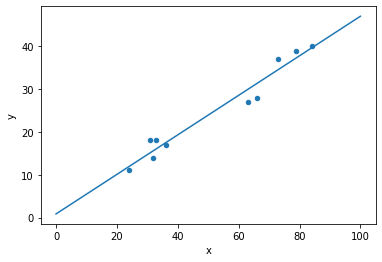

In [2]:
# axis=0 : 列方向、axis=1 行方向
x_bar, y_bar = df.mean()[0], df.mean()[1]

# pandas 1.1 未満は cov は不偏分散を返す
# そのため、N-1/N に相当する 0.9 を掛けて、通常の分散に直す必要がある
s_xx, s_xy = df.cov().iloc[0,0]*0.9, df.cov().iloc[0, 1]*0.9

a_hat_1 = s_xy/s_xx
a_hat_0 = y_bar - a_hat_1 * x_bar

x_lin = np.linspace(0,100, 100)

df.plot.scatter(x="x", y="y")
plt.plot(x_lin, a_hat_0 +  a_hat_1*x_lin)

###  scikit-learn.linear_model.LinearRegressionの使用

scipy の最小二乗法の実装（scipy.linalg.lstsq）を使用している。勾配降下法を用いていないので、変数は標準化せずそのまま入力すれば良い。

0.46163394979907 0.8488712154684492


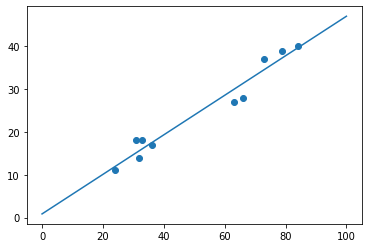

In [3]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()

# そのまま df["x"] を引数に与えると、ValueError: Expected 2D array, got 1D array instead:　と怒られる
# df["x"].shape = (10,) の1次元配列であるが、2次元配列（n行1列のデータ, 縦ベクトル）として与えなければならない
# x ... 2次元ベクトル（縦ベクトル）
# y ... 1次元ベクトル
slr.fit(df[["x"]].values, df["y"].values)

x_test = np.linspace(0,100,100).reshape(-1,1)
y_pred = slr.predict(x_test)

plt.scatter(df["x"], df["y"])
plt.plot(x_test, y_pred)

print(slr.coef_[0], slr.intercept_)

### scipy.least_squares

scipy.least_squares では以下の式を最小化することを目的とする。
$$
\frac{1}{2} \sum_{i=1}^n \left(\rho (f_i (x)^2 \right)
$$
ここで、$f(x)$は残差（residual)、$\rho(\cdot)$は損失関数 (loss function) を表す。損失関数を用いることで、残差の外れ値の影響を吸収している。`least_squares`では様々な損失関数に対応していて、デフォルトは linear（デフォルト設定）：$\rho(z)=z$であり、一般的な最小二乗法を表す。

In [4]:
from scipy.optimize import least_squares
import numpy as np

#  第一引数に対して最小化を行う
def func(p, x, y):
    return y-(p[1]*x+p[0])

# func : 残差
# [0, 0] : パラメーター（傾き、切片）の初期値を指定
# args : 訓練用データ
results = least_squares(func, [0,0], args=(df["x"], df["y"]))
print(results.x[0], results.x[1])

0.8488712154684471 0.46163394979907013


### numpy.polyfit

直線を求める基本的な最小二乗法による回帰分析は、numpyのpolyfitを用いることでより簡単に実装することができる（NumPy 1.14以上は別の`polynomial`メッソッドの使用が推奨されている）。このメソッドは

$$
E = \sum |p(x_j)-y_j|^2
$$

を最小化することで、係数を求めている。この中身は

$$
x_i ^n  p_0+ ... + x_i p_{n-1} + p_{n} = y_i
$$

を想定した1次関数である。メソッドの`digit`引数は常識の$n$に対応しており、$n=1$であれば$ax+b$のよく見る１次関数でのフィッティングを行うことと同値。

In [5]:
import numpy as np

z = np.polyfit(df["x"].to_numpy(), df["y"].to_numpy(), 1)
z

array([0.46163395, 0.84887122])

## 多項式回帰

ここまでは

$$
y=a_0 + a_1x
$$

の説明変数と目的変数の関係が線形である回帰式に従って分析を行っていた。ここでは1変数多項式回帰を行ってみる。

$$
y = a_0 + a_1x + a_2x^2 + ... + a_dx^d
$$

ここで$d$は次数を表す。説明変数は次数が上がっているが、パラメーターはどこまでも線形であることに留意。

以下の例では$d=3$の多項式で回帰分析を行ってみる。

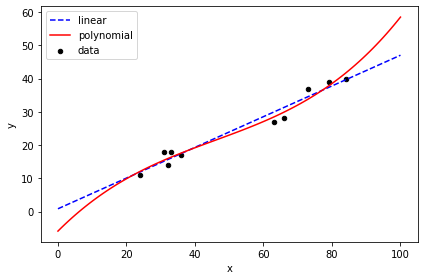

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# 線形フィット
lr = LinearRegression()
lr.fit(df[["x"]], df["y"])

# 多項式フィット
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=3)
x_quad = quadratic.fit_transform(df[["x"]])
pr.fit(x_quad, df["y"].values)

# プロット
fig, axes = plt.subplots()

x_data = np.linspace(0,100,100)[:, np.newaxis]

axes.plot(x_data, lr.predict(x_data), color="blue", linestyle="--", label="linear")
axes.plot(x_data, pr.predict(quadratic.fit_transform(x_data)), color="red", label="polynomial")
df.plot("x", "y", kind="scatter", ax=axes, color="black", label="data")

axes.legend()

plt.tight_layout()
plt.show()

# §5. 線形重回帰

説明変数が複数ある場合、目的変数は：

$$
y_i = a_0 + a_1 x_1 + a_2 x_2 + ... a_p x_p
$$

として表すことができる。これを線形重回帰モデルと呼ぶ。重回帰の場合には、$(x_0,...,x_p), y$の$p+1$次元空間におけるデータを超平面で説明することとなる。重回帰分析も単回帰分析と同様、予測誤差の平方和が最小となるようにパラメータ（$a_0...a_p$）を推定する。ただし単回帰の場合と異なり、それぞれの係数で偏微分した$p$元連立方程式を解くこととなる。

In [7]:
import pandas as pd
import numpy as np

df = pd.DataFrame( {
    "y" : [22, 36, 24, 22, 27, 29, 26, 23, 31, 24, 23, 27, 31, 25, 23],
    "x1" : [28, 46, 39, 25, 34, 29, 38, 23, 42, 27, 35, 39, 38, 32, 25],
    "x2" : [146, 169, 160, 156, 161, 168, 154, 153, 160, 152, 155, 154, 157, 162, 142],
    "x3" : [34, 57, 48, 38, 47, 50, 54, 40, 62, 39, 46, 54, 57, 53, 32],
})
df

,y,x1,x2,x3
0,22,28,146,34
1,36,46,169,57
2,24,39,160,48
3,22,25,156,38
4,27,34,161,47
5,29,29,168,50
6,26,38,154,54
7,23,23,153,40
8,31,42,160,62
9,24,27,152,39


`mlxtend`ライブラリを用いることで、データセットの特性を可視化することができる。これらはヒストグラムもしくは散布図であり、低レベルの情報を見ることができる。分析する前の重要な相関関係の把握を行うことができる（教科書のデータセットでは数が少ないのであまり有用ではないかもしれないが）。

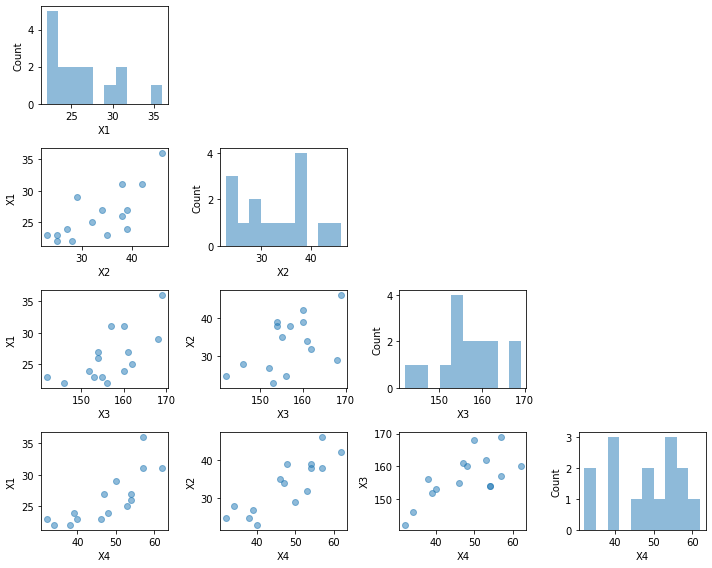

In [8]:
from mlxtend.plotting import scatterplotmatrix
scatterplotmatrix(df.values, figsize=(10, 8), alpha=0.5)
plt.tight_layout()

また重要な相関関係として、共分散行列が挙げられる。これは `pandas`から直接計算させることができる。

In [9]:
# 教科書で計算されているのは分散で、pandas が返すのは不偏分散
# そのため教科書の数字に合わせるために、N-1/N を掛けている
df.cov() * 14/15

# numpy でも同様に共分散行列を計算することができる。
# >>> np.cov(df.T, ddof=0)

,y,x1,x2,x3
y,15.226667,19.666667,18.680000,26.986667
x1,19.666667,45.422222,24.933333,50.066667
x2,18.680000,24.933333,48.773333,42.560000
x3,26.986667,50.066667,42.560000,77.040000


さらに、`mlxtend`ライブラリを用いると、共分散行列をヒートマップとして可視化することができる。

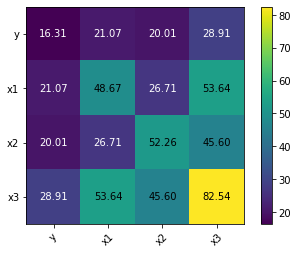

In [10]:
from mlxtend.plotting import heatmap
hm = heatmap(df.cov().values.T, row_names = df.columns, column_names = df.columns )

## sklearn.linear_model.LinearRegression

重回帰式のパラメータも`sklearn`を用いることで簡単に求めることができる。ここでは説明変数を3つで回帰分析する例を示す。まずは、説明変数と目的変数の関係が線形である以下の関係式に従った回帰分析を行ってみる。

$$
y = a_0 + a_1x_1 + a_2x_2 + a_3x_3 a_3
$$

In [11]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(df[["x1", "x2", "x3"]], df["y"])

print(slr.coef_)
print(slr.intercept_)

[0.20137689 0.17102457 0.12494278]
-13.217298316378507


# § 9 回帰係数の推定と検定

検定にはスチューデントの$t$を用いるので、実際の問題を解く前に少し見ておく。規格化したスチューデント分布の形は以下のようで：

$$
f(x, \nu) = \frac{\Gamma((\nu+1)/2)}
                {\sqrt{\pi \nu} \Gamma(\nu/2)}
            (1+x^2/\nu)^{-(\nu+1)/2}
$$

$\nu$は自由度（degees of freedom)を表している（$\nu>0$）。


scipy.stats では全ての乱数（確率分布）に対して、rv_continuous クラス（離散変数であれば rv_discrete ）を継承するようにしている（rv : random variable）。なので、どんなメソッドを持っているか知りたければ、rc_constinuousクラスの実装を見るべし。

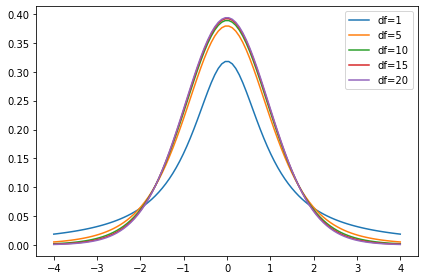

In [12]:
from scipy.stats import t as student

fig, ax = plt.subplots()
x = np.linspace(-4, 4, 100)

for deg in (1, 5, 10, 15, 20):
    ax.plot(x, student.pdf(x, deg),  label='df={}'.format(deg))
    ax.legend()
    plt.tight_layout()

plt.show()

回帰係数の推定値は自由度$n-2$のt分布に従うので（$n$はイベント数）、それを用いて以下で検討を行う。データは表5を再度使用する。

In [13]:
import pandas as pd
import numpy as np

df = pd.DataFrame( {
    "y" : [22, 36, 24, 22, 27, 29, 26, 23, 31, 24, 23, 27, 31, 25, 23],
    "x1" : [28, 46, 39, 25, 34, 29, 38, 23, 42, 27, 35, 39, 38, 32, 25],
    "x2" : [146, 169, 160, 156, 161, 168, 154, 153, 160, 152, 155, 154, 157, 162, 142],
    "x3" : [34, 57, 48, 38, 47, 50, 54, 40, 62, 39, 46, 54, 57, 53, 32],
})

In [14]:
print(pd.__version__)
print(np.__version__)

1.0.3
1.18.2


スチューデント$t$を計算する。

$$
|t| = \frac{\hat{a_1} - a_1^{0}}{\sqrt{V_e/(ns_{xx})}}
$$

ここで各量は次のようである：

- $\hat{a_1}$ : 回帰係数
- $a_1^{0}$：仮説における真の値（いまは$a=0$を検定したい）
- $V_e$：不偏分散
$$
V_e = n \left(s_{yy} - \frac{s_{xy}^2}{s_{xx}} \right)
$$
- $s_{xx}$：分散

pandas, numpyを用いて各量を計算すると次のようになる。

(1) 回帰係数

In [15]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(df[["x1"]], df["y"])

a_1 = slr.coef_[0]
a_0 = slr.intercept_

print("切片", a_0)
print("傾き", a_1)

切片 11.767514677103712
傾き 0.4329745596868886


(2) 不偏分散, 分散

In [16]:
ncoef_x = (len(df["x1"])-1)/len(df["x1"])
ncoef_y = (len(df["y"])-1)/len(df["y"])

ve = len(df['x1']) * ( df["y"].var() * ncoef_y - df[["x1", "y"]].cov().iloc[0, 1] **2 /df["x1"].var() * ncoef_x) / (len(df["x1"])-2)
sxx = df["x1"].var() * ncoef_x

print("不偏分散", ve)
print("分散", sxx)

不偏分散 7.744038837874457
分散 45.422222222222224


求めた数量から、検定を行う。ここでは両側検定を行っていて、$\alpha=0.99$と設定した。そのため `ppf` (percent point function) の引数では 1-0.005を渡す必要がある。この`ppf`は片側$p$となるときの$t$の値を返してくれる。

In [17]:
t_data = a_1/np.sqrt(ve/len(df['x1'])/sxx)
t_p995 = student.ppf(0.995, len(df["x1"])-2) 

t_data > t_p995

True

t_data は$H_0 : a_1=a_1^0$のもとでの$t$の値であるが、これはほとんど起こり得ない事がわかる。ゆえに、そもそもの仮説$H_0$が間違っていた、と結論づけることができる。仮説$H_0$は危険率$\alpha=0.01$で棄却される。

(ii) $a_{0,1}$の95%信頼区間を求める問題。

いま、それぞれのパラメータを含んだ形で、自由度$n-2$の$t$分布に従う次式で表されている。

$$
t = \frac{\hat{a_1}-a_1}{\sqrt{V_e/ns_{xx}}} \\ 
t = \frac{\hat{a_0}-a_0}{\sqrt{V_e\left( \frac{1}{n} + \frac{\bar{x}^2}{ns_{xx}} \right) }}
$$

以上を変形すると、それぞれの信頼区間は次式のように求まる（$t_\alpha(n-2)$は信頼率$1-\alpha$の自由度$n-2$の$t$分布）。

$$
\hat{a_1} - t_\alpha(n-2)\sqrt{V_e/ns_{xx}} < a_1 < \hat{a_1} + t_\alpha(n-2)\sqrt{V_e/ns_{xx}}
$$

$$
\hat{a_0} - t_\alpha(n-2)\sqrt{V_e\left( \frac{1}{n} + \frac{\bar{x}^2}{ns_{xx}} \right) }
 < a_0
 <\hat{a_0} + t_\alpha(n-2)\sqrt{V_e\left( \frac{1}{n} + \frac{\bar{x}^2}{ns_{xx}} \right) }
$$

In [18]:
student.ppf(1-0.025, len(df["x1"])-2) * np.sqrt(ve/(len(df["x1"])*sxx))

0.23032008415028335

In [19]:
student.ppf(1-0.025, len(df["x1"])-2) * np.sqrt(ve * (1/len(df["x1"]) + df["x1"].mean()**2/len(df["x1"])/sxx ) )

7.832689084835906

以上から、$11.77 \pm 7.83$と、$0.43\pm0.23$がそれぞれ$a_0$と$a_1$の両側95%信頼区間である。

# §10. 予測値の区間推定

In [20]:
import pandas as pd
import numpy as np

df_5 = pd.DataFrame( {
    "y" : [22, 36, 24, 22, 27, 29, 26, 23, 31, 24, 23, 27, 31, 25, 23],
    "x1" : [28, 46, 39, 25, 34, 29, 38, 23, 42, 27, 35, 39, 38, 32, 25],
    "x2" : [146, 169, 160, 156, 161, 168, 154, 153, 160, 152, 155, 154, 157, 162, 142],
    "x3" : [34, 57, 48, 38, 47, 50, 54, 40, 62, 39, 46, 54, 57, 53, 32],
})

(1) 握力が30kgであるような生徒のボール投げの期待値$E(y)$の95%信頼区間

まず単回帰分析の問題と同様、データを説明する直線 $y=a_0 + a_1 x$のパラメータの値を求める。

In [21]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(df[["x1"]], df["y"])

a_hat_1 = slr.coef_[0]
a_hat_0 = slr.intercept_

In [22]:
n = len(df["x1"])
syy = df["y"].var()
sxx = df["x1"].var()
sxy = df[["x1", "y"]].cov().iloc[0,1]
ve = n * ( syy - sxy**2/sxx) / (n-2)

$x_0=30$ のときの期待値の95%信頼区間は

In [23]:
from scipy.stats import t as student

def e_y_ci(x0):
    low = a_hat_0 + a_hat_1 * x0 - student.ppf(0.025, n-2) * np.sqrt( ( 1/n + (x0 - df["x1"].mean() )**2/n/sxx ) * ve ) 
    high = a_hat_0 + a_hat_1 * x0 + student.ppf(0.025, n-2) * np.sqrt( ( 1/n + (x0 - df["x1"].mean() )**2/n/sxx ) * ve )
    
    return low, high

print(e_y_ci(30))

(26.53749630393576, 22.976006631484978)


$x_0$ がある値のときの$y$の95%信頼区間は

In [24]:
def y_ci(x0):
    low = a_hat_0 + a_hat_1 * x0 - student.ppf(0.025, n-2) * np.sqrt( ( 1 + 1/n + (x0 - df["x1"].mean() )**2/n/sxx ) * ve ) 
    high = a_hat_0 + a_hat_1 * x0 + student.ppf(0.025, n-2) * np.sqrt( ( 1 + 1/n + (x0 - df["x1"].mean() )**2/n/sxx ) * ve )
    
    return low, high

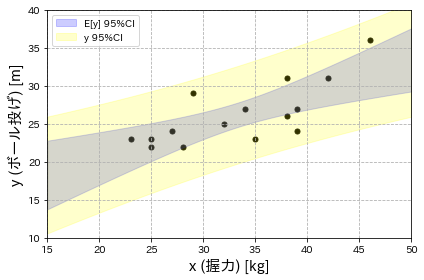

In [25]:
plt.rcParams['font.family'] = 'IPAexGothic'

fig, axes = plt.subplots()
df.plot(x="x1", y="y", kind="scatter", ax=axes, marker='o', color="black", s=25)

x_data = np.linspace(15, 50, 100)
axes.fill_between(x_data, e_y_ci(x_data)[0], e_y_ci(x_data)[1], alpha=0.2, color="blue", label="E[y] 95%CI")

axes.fill_between(x_data, y_ci(x_data)[0], y_ci(x_data)[1], alpha=0.2, color="yellow", label="y 95%CI")

axes.set_xlabel("x (握力) [kg]", fontsize=15)
axes.set_ylabel("y (ボール投げ) [m]", fontsize=15)

axes.set_xlim(15,50)
axes.set_ylim(10,40)

axes.grid(ls='--')

axes.legend(loc="best")

fig.tight_layout()